# Biodiversity Project
For this project, we will interpret data from the National Parks Service about endangered species in different parks.

### Import needed modules
The next cell will hold the modules that we will use in the course of this data analysis.

In [301]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency


## Loading and Describing the data
A good starting point for every DataScience project. We need to check what we actually have available.
Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).
Once we understand the data at our disposal, we can start formulating questions that we can answer with this data.

In [190]:
# Codecademy has provided 2 CSV files
# Start by loading them usinf Pandas
observations = pd.read_csv("./biodiversity_starter/observations.csv")
species_info = pd.read_csv("./biodiversity_starter/species_info.csv")

### Spiecies_info
I will focus first on describing the contents of spiecies_info.

In [5]:
print(species_info.columns) # Which columns are available.
print(species_info.dtypes) # Which types of data. Does this make sense?
print(species_info.describe()) # short summary statistics
print(species_info.head(10)) # and visualy check the first 10 rows.

Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object')
category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object
              category    scientific_name        common_names  \
count             5824               5824                5824   
unique               7               5541                5504   
top     Vascular Plant  Castor canadensis  Brachythecium Moss   
freq              4470                  3                   7   

       conservation_status  
count                  191  
unique                   4  
top     Species of Concern  
freq                   161  
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   
5   Mammal         Odocoileus v

It seems that this is a table on all the spiecies that we will have observations from. Included are category, scientific name, common names, and conservation status. The collumn conservation status contains NaN values, which might indicate species of least concern.

We will now dive a bit deeper into the collumns of the Species info csv.

#### Data cleanup.
One of the points of attention in spiecies info is that there is a count of 5824 scientific_names reported, but only 5541 of them are unique. As suposedly species name is unique, let us investigate what is going on.

In [191]:
print(species_info[species_info.duplicated(subset="scientific_name")].head(5))

     category         scientific_name                          common_names  \
3017   Mammal          Cervus elaphus                    Rocky Mountain Elk   
3019   Mammal  Odocoileus virginianus  White-Tailed Deer, White-Tailed Deer   
3020   Mammal             Canis lupus                       Gray Wolf, Wolf   
3022   Mammal           Puma concolor           Cougar, Mountain Lion, Puma   
3025   Mammal        Lutra canadensis                           River Otter   

     conservation_status  
3017                 NaN  
3019                 NaN  
3020         In Recovery  
3022                 NaN  
3025                 NaN  


So we know that a _Cervus elaphus_ and _Puma concolor_ are posted at least twice. Let us inspect the entries.

In [194]:
print(species_info[species_info.apply(lambda row: row["scientific_name"]=="Cervus elaphus", axis=1)])
print(species_info[species_info.apply(lambda row: row["scientific_name"]=="Puma concolor", axis=1)])

     category scientific_name        common_names conservation_status
4      Mammal  Cervus elaphus       Wapiti Or Elk                 NaN
3017   Mammal  Cervus elaphus  Rocky Mountain Elk                 NaN
     category scientific_name                 common_names conservation_status
16     Mammal   Puma concolor      Panther (Mountain Lion)                 NaN
3022   Mammal   Puma concolor  Cougar, Mountain Lion, Puma                 NaN
4451   Mammal   Puma concolor                Mountain Lion                 NaN


It seems that more common names of the same spiecies turned up, and instead of adding to the old entry, somebody created a new one. We can join the enties together, and delete the duplicates to get a cleaner dataframe.

In [195]:
def cleanup(dataframe, key_column, property_column):
    """Function to clean up a dataframe.
     One column is supposed to be the key_column, while a second one holds properies for that key.
     In case of a duplicate entry in the key collumn:
      properties are added to the first instance, and the second instance is dropped.
    This is repeated until no more duplicates are found.
    """
    cleaned = False
    while not cleaned:
        duplicated = dataframe[dataframe.duplicated(subset=key_column)]
        if duplicated.shape[0] == 0:
            cleaned = True
        else:
            key = duplicated.iloc[0][key_column]
            label = duplicated.index[0]
            entry = duplicated.iloc[0][property_column]
            label2 = dataframe[dataframe.apply(lambda row: row[key_column]==key, axis=1)].index[0]
            dataframe.loc[label2, property_column] += ", " + entry
            dataframe = dataframe.drop(label)
            
    return dataframe


species_cleaned = cleanup(species_info, "scientific_name", "common_names")

with category.

In [196]:
print(f"Number of species: {species_cleaned.category.nunique()} \n")
print(f"List of species present in the survey: {species_cleaned.category.unique()} \n")
print("Distribution of species amongst categories: ")
print(species_cleaned.groupby("category").size())
print("")
print("Distribution in percentage of total spiecies:")
print(species_cleaned.groupby("category").size()/species_cleaned.category.size*100)

Number of species: 7 

List of species present in the survey: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant'] 

Distribution of species amongst categories: 
category
Amphibian              79
Bird                  488
Fish                  125
Mammal                176
Nonvascular Plant     333
Reptile                78
Vascular Plant       4262
dtype: int64

Distribution in percentage of total spiecies:
category
Amphibian             1.425735
Bird                  8.807075
Fish                  2.255910
Mammal                3.176322
Nonvascular Plant     6.009746
Reptile               1.407688
Vascular Plant       76.917524
dtype: float64


We see that of all the species tracked, the vast majority (76.9%) are _vascular plants_. _Birds_ are a distant second with almost 9%.

A first thing to investigate would be to see if the same percantages are reflected in conservation satus, or if that is skewed towards other types of species.
In order to do so, we will replace the NaN with _least_concern_.

In [197]:
species_cleaned.conservation_status.fillna("least_concern", inplace=True)
print(f"There are {species_cleaned.conservation_status.nunique()} types of conservation status.")
print(f"They are: {species_cleaned.conservation_status.unique()}")

There are 5 types of conservation status.
They are: ['least_concern' 'Species of Concern' 'Endangered' 'Threatened'
 'In Recovery']


Now, how does this play out amongst categories?

In [198]:
conservation_status = species_cleaned.groupby(["conservation_status", "category"])["scientific_name"].count().unstack()

conservation_status

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,NaN,NaN,NaN,NaN
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,NaN,3.0,2.0,NaN,NaN,2.0
least_concern,72.0,413.0,115.0,146.0,328.0,73.0,4216.0


This is a bit too much info to process easily.
In order to clarify things, we will simplify the data to two possible status: Protected and not Protected.

In [200]:
species_cleaned["is_protected"] = species_cleaned["conservation_status"] != "least_concern"

print("Unprotected and Protected # of species per category")
print(species_cleaned.groupby(["category",  "is_protected"])["scientific_name"].count().unstack())

print("")

print("Unprotected and Protected % of species per category")
(species_cleaned.groupby(["category",  "is_protected"])["scientific_name"].count()/(species_cleaned.groupby("category").size())*100).unstack()

Unprotected and Protected # of species per category
is_protected       False  True 
category                       
Amphibian             72      7
Bird                 413     75
Fish                 115     10
Mammal               146     30
Nonvascular Plant    328      5
Reptile               73      5
Vascular Plant      4216     46

Unprotected and Protected % of species per category


is_protected,False,True
category,,
Amphibian,91.139241,8.860759
Bird,84.631148,15.368852
Fish,92.000000,8.000000
Mammal,82.954545,17.045455
Nonvascular Plant,98.498498,1.501502
Reptile,93.589744,6.410256
Vascular Plant,98.920695,1.079305


So as a first point, it seems that Birds and Mammals with 15% and 17% of protected spiecies are doing the worst. Next is the group containing Amhibians, Fish, and Reptiles. Both Vascular and Nonvascular plants seem to be the least affected types of spiecies.
To see if these differences are actually significant and the groups well defined, we will calculate the P value for:
Mamal vs. Bird, Mammal vs. Fish, Fish vs. Reptile, Fish vs. Nonvascular Plant.
We expect no significal difference for Mamal vs. Bird or Fish vs. Reptile.

In [201]:
_, p_value, _, _ = chi2_contingency([[30, 146],[75, 413]])
print("P_values smaller than 0.05 are typically considered indicators of a significant difference.")
print(f"The p_value for a chi2 difference between Mammals and Birds is: {p_value}.")

_, p_value, _, _ = chi2_contingency([[30, 146],[10, 115]])
print(f"The p_value for a chi2 difference between Mammals and Fish is: {p_value}.")

_, p_value, _, _ = chi2_contingency([[5, 73],[10, 115]])
print(f"The p_value for a chi2 difference between Reptiles and Fish is: {p_value}.")

_, p_value, _, _ = chi2_contingency([[5, 328],[10, 115]])
print(f"The p_value for a chi2 difference between Nonvascular plants and Fish is: {p_value}.")

P_values smaller than 0.05 are typically considered indicators of a significant difference.
The p_value for a chi2 difference between Mammals and Birds is: 0.6875948096661336.
The p_value for a chi2 difference between Mammals and Fish is: 0.03521990485242024.
The p_value for a chi2 difference between Reptiles and Fish is: 0.8844187103100194.
The p_value for a chi2 difference between Nonvascular plants and Fish is: 0.0014420708083000965.


It seems that we judged the categories correctly, and the calculated p_values support our three groups.

### Observations
Now it is time to turn our attention to the observation dataset.

In [202]:
print(observations.columns) # Which columns are available.
print(observations.dtypes) # Which types of data. Does this make sense?
print(observations.describe()) # short summary statistics
print(observations.head(10)) # and visualy check the first 10 rows.

Index(['scientific_name', 'park_name', 'observations'], dtype='object')
scientific_name    object
park_name          object
observations        int64
dtype: object
       observations
count  23296.000000
mean     142.287904
std       69.890532
min        9.000000
25%       86.000000
50%      124.000000
75%      195.000000
max      321.000000
                     scientific_name                            park_name  \
0                 Vicia benghalensis  Great Smoky Mountains National Park   
1                     Neovison vison  Great Smoky Mountains National Park   
2                  Prunus subcordata               Yosemite National Park   
3               Abutilon theophrasti                  Bryce National Park   
4           Githopsis specularioides  Great Smoky Mountains National Park   
5  Elymus virginicus var. virginicus               Yosemite National Park   
6                   Spizella pusilla            Yellowstone National Park   
7                  Elymus multisetus  Gr

Here we have a column indicating the scientific name of the spiecies observed, another is the name of the park, and last is how many of those spiecies were observed in said park.

We can see which park has the most observation of spiecies.

In [203]:
observations.groupby("park_name")["observations"].sum()

park_name
Bryce National Park                     576025
Great Smoky Mountains National Park     431820
Yellowstone National Park              1443562
Yosemite National Park                  863332
Name: observations, dtype: int64

In [204]:
observations.groupby(["park_name"])["scientific_name"].count()

park_name
Bryce National Park                    5824
Great Smoky Mountains National Park    5824
Yellowstone National Park              5824
Yosemite National Park                 5824
Name: scientific_name, dtype: int64

Interestingly, in each park we have 5824 observations, while there are only 5541 unique species names.

In [227]:
grouped = observations.groupby(["park_name", "scientific_name"]).size().reset_index(name="count")
duplicated = grouped[grouped["count"] > 1].reset_index(drop=True)
print("Amount of duplicated observations in each park:")
print(duplicated.groupby("park_name").size())
print("")
print("Are some species duplicated more than once? Let us see the maximum duplication number.")
print(duplicated["count"].max())
print("")
print("How many unique species are duplicated?")
duplicated.scientific_name.nunique()

Amount of duplicated observations in each park:
park_name
Bryce National Park                    274
Great Smoky Mountains National Park    274
Yellowstone National Park              274
Yosemite National Park                 274
dtype: int64

Are some species duplicated more than once? Let us see the maximum duplication number.
3

How many unique species are duplicated?


274

The dataset provided from Codecademy seems to have some unexpected structure. It is highly unlikely that over 4 national parks of different sizes, each park has exactly the same number of duplicated observations.

Let us investigate if the duplicated observations are evenly distributed over all categories, or if there is some skewedness.

In [248]:
result =  pd.merge(duplicated, species_cleaned, how='left', on='scientific_name')
print("Duplicated observations per park and per species: ")
result.groupby(["category", "park_name"]).size()



Duplicated observations per park and per species: 


category        park_name                          
Amphibian       Bryce National Park                      1
                Great Smoky Mountains National Park      1
                Yellowstone National Park                1
                Yosemite National Park                   1
Bird            Bryce National Park                     31
                Great Smoky Mountains National Park     31
                Yellowstone National Park               31
                Yosemite National Park                  31
Fish            Bryce National Park                      2
                Great Smoky Mountains National Park      2
                Yellowstone National Park                2
                Yosemite National Park                   2
Mammal          Bryce National Park                     33
                Great Smoky Mountains National Park     33
                Yellowstone National Park               33
                Yosemite National Park                  33
Rept

Not only do all parks have the same number of duplicate observations, they even have the same distribution over all species. At first glance this distribution seems skewed, but let us put it in percentages.

In [250]:
original_species_nr = species_cleaned.groupby("category").size()
spiecies_duplicated_percent = result[result["park_name"] == "Yellowstone National Park"].groupby("category").size()
for row in original_species_nr.keys():
    if row in spiecies_duplicated_percent.keys():
        spiecies_duplicated_percent[row] = spiecies_duplicated_percent[row]/original_species_nr[row]*100
    else:
        spiecies_duplicated_percent[row] = 0

spiecies_duplicated_percent

category
Amphibian             1.265823
Bird                  6.352459
Fish                  1.600000
Mammal               18.750000
Reptile               1.282051
Vascular Plant        4.833412
Nonvascular Plant     0.000000
dtype: float64

It seems that mammals, birds and vascular plants are most prone to be reported as observed multiple times.

As we do not have time-series data, we cannot study if the conservation status helps species recover.

### Focussing on a single type of animal.
I like squirrels. What we can address is which park has the most types of squirrel, and where they are most observed.

First, we have to go over the common_names to find out which animals are squirrels. As is, this will be difficult. With a bit of regex we should be able to make it work.

In [276]:
# get squirrels, unsure about possible capitalization.
squirrels = species_cleaned[species_cleaned.apply(
    lambda row: (bool(re.search(r"[sS]quirrel", row["common_names"]))
                 and row["category"]=="Mammal"), axis=1)]

print(f"There are {squirrels.shape[0]} types of squirrel. ")
print(f"Of which {squirrels.is_protected.sum()} is protected.")

There are 12 types of squirrel. 
Of which 1 is protected.


Ok, so where can we see them?

In [278]:
# By inner joining squirrels to observations we will only have the cells we need.
squirrel_observations = pd.merge(observations, squirrels, how='inner', on='scientific_name')
squirrel_observations.groupby("park_name").size()

park_name
Bryce National Park                    12
Great Smoky Mountains National Park    12
Yellowstone National Park              12
Yosemite National Park                 12
dtype: int64

Nice, all squirrel species are prtesent in all parks.
Where are the most?

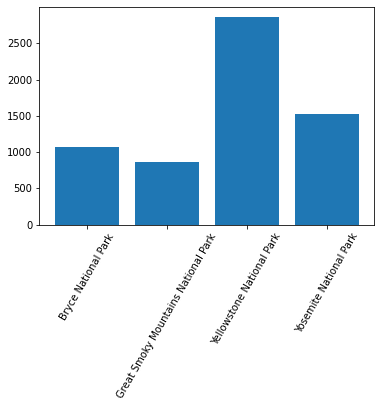

In [299]:
parks = list(squirrel_observations.groupby("park_name").groups.keys())
plt.bar(parks, squirrel_observations.groupby("park_name").observations.sum())
plt.xticks(rotation=60)
plt.show()

Is the protected species also highly present in Yellowstone?

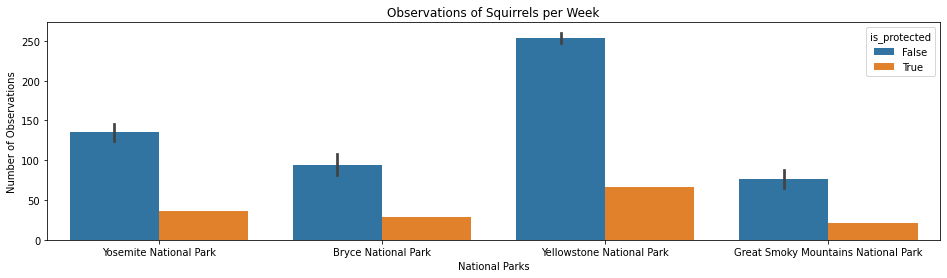

In [303]:
plt.figure(figsize=(16, 4))
sns.barplot(x=squirrel_observations.park_name, y= squirrel_observations.observations, hue=squirrel_observations.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Squirrels per Week')
plt.show()

It seems that all parks are good for people that like to spot squirrels.

## Conclusions
